In [25]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from scipy import stats

In [2]:
def model_perform(X_train,y_train, X_test, y_test, model, name, verbose = 0 ):
    # train 
    model.fit(X_train, y_train)

    # test 
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    if verbose == 1 :
        print(' MAE {} '.format(mean_absolute_error(y_pred_test,y_test)))
        print(' MSE {} '.format(mean_squared_error(y_pred_test,y_test)))
        print(' R2 {} '.format(r2_score(y_train,y_pred_train)))
    else : 
        pass 
    
    result = {}
    result['mae'] = np.round(mean_absolute_error(y_pred_test,y_test),5)
    result['mse'] = np.round(mean_squared_error(y_pred_test,y_test),5)
    result['R2'] = np.round(r2_score(y_train,y_pred_train),5)
    result['name'] = name
    result['feature_size'] = X_train.shape[1]
    result['train_size'] = X_train.shape[0]
    result['test_size'] = X_test.shape[0]

    return model, y_pred_test, y_pred_train, result 

def show_error_pattern(y_pred, y_test):
    result_test = pd.DataFrame()
    result_test['score'] = y_pred
    result_test['type'] = 'predict'
    result_test['idx'] = np.arange(result_test.shape[0])

    result_test2 = pd.DataFrame()
    result_test2['score'] = np.squeeze(y_test)
    result_test2['type'] = 'test'
    result_test2['idx'] = np.arange(result_test2.shape[0])

    df_result = pd.concat([result_test2,result_test])

    sns.lineplot(data=df_result, x="idx", y='score', hue="type")


def bulk_train(df_input, drop_column, target_column, dataset_name, verbose = 0):

    error_report = []
    model_dict = {}

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)
    

    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    regr = RandomForestRegressor(random_state=0)
    model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose = verbose )
    error_report.append(result_rf)

    xgbr = XGBRegressor(random_state=0)
    model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name='xgb', verbose = verbose)
    error_report.append(result_xgb)

    # SVR 
    svr = SVR(kernel='poly')
    model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name='svr',verbose = verbose)
    error_report.append(result_svr)

    model_dict['rf'] = model_regr
    model_dict['xgbr'] = result_xgb
    model_dict['svr'] = result_svr
    
    df_report = pd.DataFrame(error_report)
    df_report['dataset'] = dataset_name
    return  model_dict, df_report

# Bulk Training 

In [3]:
# zomato only
df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']

target_column = 'rating'
model_zom, report_zom = bulk_train(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only')

<AxesSubplot:>

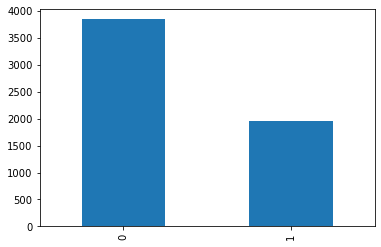

In [4]:
df_zom['is_chain'].value_counts().plot(kind='bar')

In [5]:
df_zom['is_chain'].value_counts()

0    3844
1    1959
Name: is_chain, dtype: int64

In [6]:
# zomato geo 250
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'
model_zom_geo_250, report_zom_geo_250 = bulk_train(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_geo_250')

In [7]:
# zomato geo 500
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'
model_zom_geo_500, report_zom_geo_500 = bulk_train(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_geo_500')

In [8]:
# zomato geo 1000
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'
model_zom_geo_1000, report_zom_geo_1000 = bulk_train(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_geo_1000')

In [9]:
all_df_error_report = pd.concat([report_zom, report_zom_geo_250, report_zom_geo_500, report_zom_geo_1000])

In [10]:
all_df_error_report

,mae,mse,R2,name,feature_size,train_size,test_size,dataset
0,0.07341,0.00879,0.79772,rf,4,5106,697,zomato_only
1,0.07351,0.00880,0.61203,xgb,4,5106,697,zomato_only
2,0.07701,0.00950,0.07103,svr,4,5106,697,zomato_only
0,0.07464,0.00916,0.86929,rf,22,5106,697,zomato_geo_250
1,0.07607,0.00947,0.72956,xgb,22,5106,697,zomato_geo_250
2,0.08052,0.01086,0.15102,svr,22,5106,697,zomato_geo_250
0,0.07307,0.00883,0.87909,rf,22,5106,697,zomato_geo_500
1,0.07347,0.00914,0.81792,xgb,22,5106,697,zomato_geo_500
2,0.07705,0.00987,0.20959,svr,22,5106,697,zomato_geo_500
0,0.07176,0.00861,0.88079,rf,22,5106,697,zomato_geo_1000


In [11]:
model_zomato = [0.07870, 0.07612, 0.07810]
model_zomato_poi = [0.07463, 0.07452, 0.07636]
ttest_ind(model_zomato, model_zomato_poi)

(2.5174827606399686, 0.06553232501071184, 4.0)

In [12]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-12


In [13]:
# all_df_error_report.reset_index().drop('index',axis=1).to_excel('data/ml_perform_{}.xlsx'.format(today),index=False)

# Load data 

##  Zomato data only 

In [14]:
# df = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)
# df['rank_res_type'] = df['rank_res_type'].astype(int)
# df['rank_fac'] = df['rank_fac'].astype(int)


drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'

# scaled the values 
features_columns = df_zom.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom[features_columns]), columns = features_columns)
    

In [34]:
df_zom.sort_values('rest_price_idr',ascending=False)

,index,url,rest_price_idr,review,lat,long,is_chain,rating,new_code_res_type,rank_res_type,new_code_fac,rank_fac
1224,1419,https://www.zomato.com/jakarta/tatemukai-thamr...,3500,180.0,-6.195219,106.820996,0,4.3,0,8,0,1343
1571,1833,https://www.zomato.com/jakarta/ebeya-steakhous...,3000,91.0,-6.224083,106.809788,0,4.2,0,197,0,1030
929,1054,https://www.zomato.com/jakarta/sushi-ichi-pull...,3000,60.0,-6.193305,106.823805,0,4.0,0,8,0,1162
1539,1794,https://www.zomato.com/jakarta/namaaz-dining-s...,2400,926.0,-6.238588,106.806963,0,4.9,4,0,0,1398
3210,3838,https://www.zomato.com/jakarta/ruths-chris-ste...,1900,569.0,-6.224840,106.824214,0,4.6,0,24,0,1060
...,...,...,...,...,...,...,...,...,...,...,...,...
3017,3600,https://www.zomato.com/jakarta/jeju-kitchen-1-...,0,6.0,-6.224562,106.809826,0,3.7,0,10,0,115
4314,5314,https://www.zomato.com/jakarta/just-coco-penja...,0,5.0,-6.123663,106.783042,0,3.2,0,13,2,1
2956,3524,https://www.zomato.com/jakarta/caf%C3%A9-kitsu...,0,45.0,-6.229466,106.806585,0,2.5,4,0,0,49
2734,3258,https://www.zomato.com/jakarta/toko-kopi-tuku-...,0,5.0,-6.244591,106.800649,1,3.7,1,4,2,1


<AxesSubplot:ylabel='Frequency'>

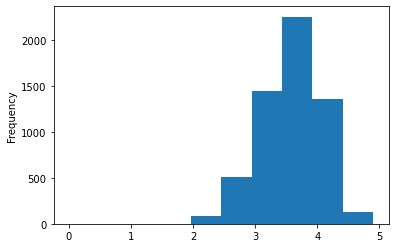

In [16]:
df_zom['rating'].plot(kind='hist')

In [17]:
df_zom.head()

,index,url,rest_price_idr,review,lat,long,is_chain,rating,new_code_res_type,rank_res_type,new_code_fac,rank_fac
0,0,https://www.zomato.com/jakarta/wakacao-1-kelap...,150,56.0,-6.167531,106.901752,0,3.8,4,0,4,0
1,1,https://www.zomato.com/jakarta/the-coffee-bean...,110,61.0,-6.157341,106.907888,1,3.0,0,91,0,883
2,2,https://www.zomato.com/jakarta/angke-kelapa-ga...,450,363.0,-6.152638,106.892576,0,4.5,2,2,0,625
3,3,https://www.zomato.com/jakarta/ikan-nila-pak-u...,100,113.0,-6.163588,106.903689,0,3.9,0,20,0,4
4,4,https://www.zomato.com/jakarta/hong-kong-sheng...,220,257.0,-6.157255,106.908430,1,4.1,0,261,0,86


## Preprocessing 

In [18]:
# split train and test 

X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review'],axis=1), df['rating'], test_size=0.3, random_state=42)

In [19]:
X_train.head()

,rest_price_idr,is_chain,rank_res_type,rank_fac
3071,0.025714,1.0,0.164015,0.015124
2860,0.028571,0.0,0.236230,0.221416
4694,0.028571,0.0,0.030600,0.011494
5696,0.028571,1.0,0.008568,0.002420
3107,0.020000,0.0,0.004896,0.021779


In [20]:
X_train.shape

(4642, 4)

 MAE 0.07519081330694027 
 MSE 0.00909165368063962 
 R2 0.8091978464585667 


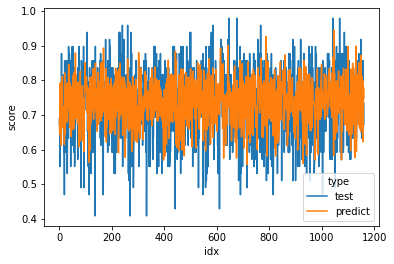

In [21]:
# random forest 

regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )
df_residual_rf = pd.DataFrame()
df_residual_rf['target'] = y_test
df_residual_rf['pred'] = y_pred_test_regr
df_residual_rf['error'] = df_residual_rf['target'] - df_residual_rf['pred']
df_residual_rf['std_error'] = (df_residual_rf['error'] - df_residual_rf['error'].mean()) / df_residual_rf['error'].std()

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

# show_error_pattern(y_pred=y_pred_train_regr, y_test=y_train)

## Statistical Test for Regression 

[Text(0.5, 1.0, 'coreelation between error and predicted -0.23607880885316052')]

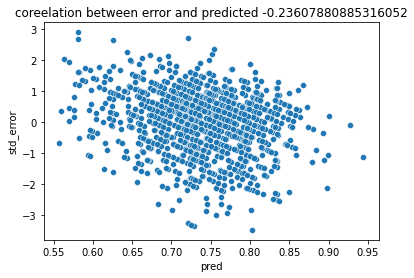

In [32]:
# examine predicted vs residual 
corr = stats.pearsonr(df_residual_rf['pred'],df_residual_rf['std_error'])[0]
sns.scatterplot(data=df_residual_rf, x="pred", y="std_error").set(title='coreelation between error and predicted {}'.format(corr)) 

[Text(0.5, 1.0, 'coreelation between actual and predicted 0.388398701817427')]

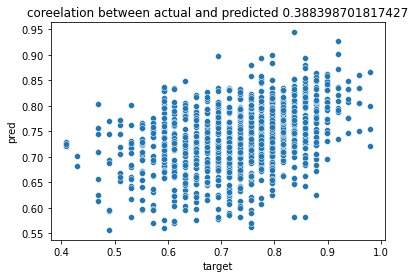

In [31]:
# correlation 
corr = stats.pearsonr(df_residual_rf['target'],df_residual_rf['pred'])[0]
sns.scatterplot(data=df_residual_rf, x="target", y="pred").set(title='coreelation between actual and predicted {}'.format(corr)) 

<AxesSubplot:title={'center':'error skewness from random forest -0.458'}, ylabel='Frequency'>

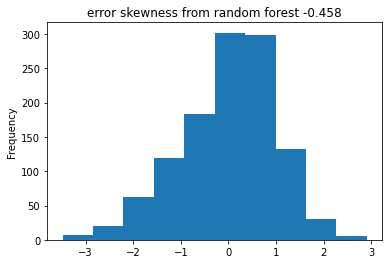

In [33]:
# plot error skewness 
title = 'error skewness from random forest {}'.format(np.round(skew(df_residual_rf['std_error']),3))
df_residual_rf['std_error'].plot(kind='hist', title = title)

 MAE 0.07440572201217642 
 MSE 0.009020749716733091 
 R2 0.8450494710709088 


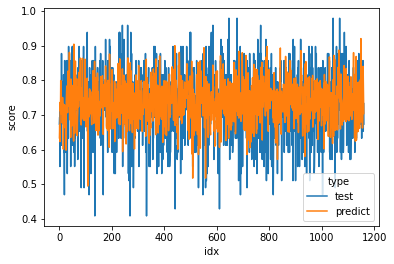

In [39]:
# XGBoost 

xgbr = XGBRegressor(random_state=0)
model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name = 'xgb', verbose = 1)
df_residual_xgb = pd.DataFrame()
df_residual_xgb['target'] = y_test
df_residual_xgb['pred'] = y_pred_test_xgbr
df_residual_xgb['error'] = df_residual_xgb['target'] - df_residual_xgb['pred']
# residual_xgb = 
show_error_pattern(y_pred=y_pred_test_xgbr, y_test=y_test)

<AxesSubplot:title={'center':'error skewness from random forest -0.519'}, ylabel='Frequency'>

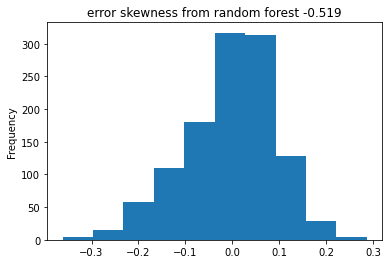

In [25]:
# plot error skewness 
title = 'error skewness from random forest {}'.format(np.round(skew(df_residual_xgb['error']),3))
df_residual_xgb['error'].plot(kind='hist',title=title)

<AxesSubplot:xlabel='pred', ylabel='error'>

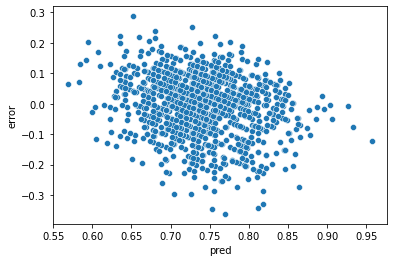

In [26]:
sns.scatterplot(data=df_residual_xgb, x="pred", y="error")

<AxesSubplot:xlabel='pred', ylabel='target'>

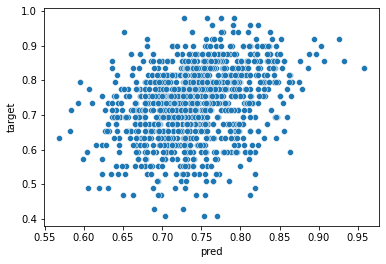

In [27]:
sns.scatterplot(data=df_residual_xgb, x="pred", y="target")

 MAE 0.0783181342834367 
 MSE 0.009529474595746507 
 R2 0.04112990751054513 


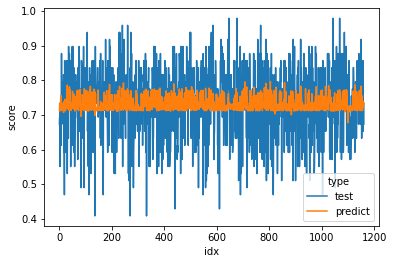

In [28]:
# SVR 
svr = SVR(kernel='poly')

model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name = 'svr',verbose = 1)
df_residual_svr = pd.DataFrame()
df_residual_svr['target'] = y_test
df_residual_svr['pred'] = y_pred_test_xgbr
df_residual_svr['error'] = df_residual_svr['target'] - df_residual_svr['pred']
show_error_pattern(y_pred=y_pred_test_svr, y_test=y_test)

<AxesSubplot:title={'center':'error skewness from svrt -0.519'}, ylabel='Frequency'>

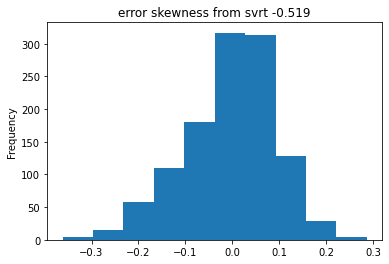

In [29]:
# plot error skewness 
title = 'error skewness from svrt {}'.format(np.round(skew(df_residual_svr['error']),3))
df_residual_xgb['error'].plot(kind='hist',title=title)

 MAE 0.1352550561745217 
 MSE 0.032014146768776564 
 R2 0.6804042643063573 


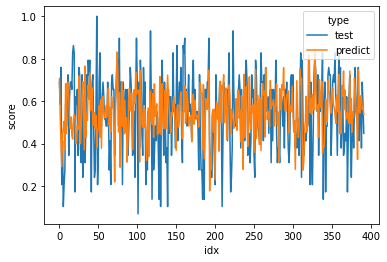

In [30]:
# chain restaurant zomato
df_zom_chain = df_zom[df_zom['is_chain']==1]

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']

target_column = 'rating'


# scaled the values 
features_columns = df_zom_chain.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom_chain[features_columns]), columns = features_columns)

X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.2, random_state=42)

regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf  = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

 MAE 0.07966177924235918 
 MSE 0.010161671858566935 
 R2 0.7040478369278351 


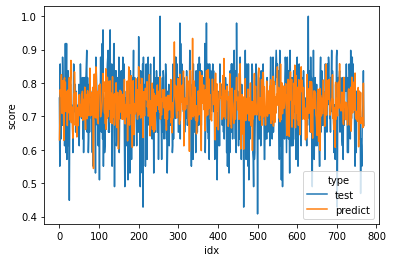

In [31]:
# non chain restaurant zomato
df_zom_non_chain = df_zom[df_zom['is_chain']==0]

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']

target_column = 'rating'


# scaled the values 
features_columns = df_zom_non_chain.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom_non_chain[features_columns]), columns = features_columns)

X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.2, random_state=42)

regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf  = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

In [57]:
# Binary classfication 

df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)
# df['rank_res_type'] = df['rank_res_type'].astype(int)
# df['rank_fac'] = df['rank_fac'].astype(int)
df_zom['binary_target'] = df_zom['rating'].apply( lambda x:0 if x < 3.5 else 1)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'

# scaled the values 
features_columns = df_zom.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom[features_columns]), columns = features_columns)
df_input_scale['binary_target'] = df_input_scale['rating'].apply( lambda x:0 if x < 0.75 else 1)


X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop([target_column,'binary_target'], axis=1), df_input_scale['binary_target'], test_size=0.2, random_state=42)


# clf = RandomForestClassifier(random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print('f1 score : {}'.format(f1_score(y_pred, y_test, average='binary')))
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

c:\Users\a.rahmadi\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:28:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score : 0.6111603188662533


In [52]:
df_input_scale['binary_target'].value_counts()

0    2909
1    2894
Name: binary_target, dtype: int64

In [53]:
df_confusion

Predicted,0,1,All
Actual,,,
0,321,268,589
1,229,343,572
All,550,611,1161


In [54]:
df_input_scale['binary_target'].value_counts()

0    2909
1    2894
Name: binary_target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

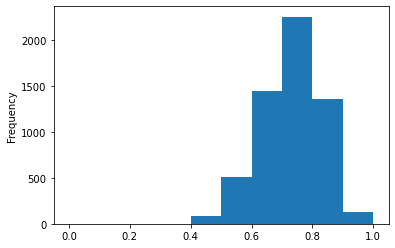

In [55]:
df_input_scale['rating'].plot(kind='hist')

# Zomato + POI 

In [34]:
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

# scaled the values 
features_columns = df_zom_poi.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom_poi[features_columns]), columns = features_columns)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop('rating',axis=1), \
    df_input_scale['rating'], test_size=0.2, random_state=42)


 MAE 0.07464328780607851 
 MSE 0.008870139781614739 
 R2 0.8750498966983922 


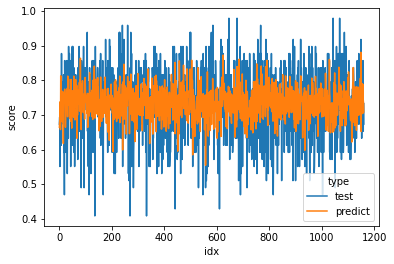

In [42]:
# random forest 

regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

 MAE 0.07440572201217642 
 MSE 0.009020749716733091 
 R2 0.8450494710709088 


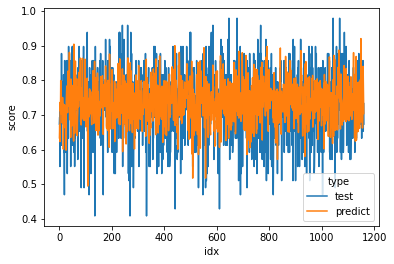

In [37]:
# XGBoost 

xgbr = XGBRegressor(random_state=0)
model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name = 'xgb',verbose = 1)

show_error_pattern(y_pred=y_pred_test_xgbr, y_test=y_test)

 MAE 0.0782919392478098 
 MSE 0.009443944130461691 
 R2 0.18729358958378117 


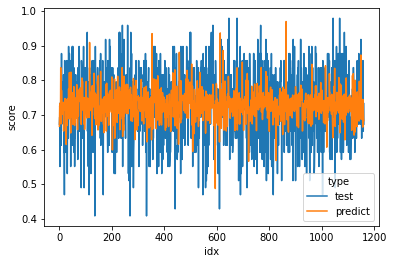

In [38]:
# SVR 
svr = SVR(kernel='poly')

model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name='svr' ,verbose = 1)

show_error_pattern(y_pred=y_pred_test_svr, y_test=y_test)

In [73]:
# Binary classfication 

df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)
# df['rank_res_type'] = df['rank_res_type'].astype(int)
# df['rank_fac'] = df['rank_fac'].astype(int)
df_zom_poi['binary_target'] = df_zom_poi['rating'].apply( lambda x:0 if x < 3.5 else 1)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash']
target_column = 'rating'

# scaled the values 
features_columns = df_zom_poi.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom_poi[features_columns]), columns = features_columns)
df_input_scale['binary_target'] = df_input_scale['rating'].apply( lambda x:0 if x < 0.75 else 1)


X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop([target_column,'binary_target'], axis=1), df_input_scale['binary_target'], test_size=0.12, random_state=42)


# clf = RandomForestClassifier(random_state=0)
clf = xgb.XGBClassifier(use_label_encoder=False,random_state=0, n_estimators = 100)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print('f1 score : {}'.format(f1_score(y_pred, y_test, average='binary')))
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

[09:00:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score : 0.6207906295754027


In [61]:
df_confusion

Predicted,0,1,All
Actual,,,
0,358,231,589
1,213,359,572
All,571,590,1161


In [60]:
df_input_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5803 entries, 0 to 5802
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rest_price_idr            5803 non-null   float64
 1   is_chain                  5803 non-null   float64
 2   rank_res_type             5803 non-null   float64
 3   rank_fac                  5803 non-null   float64
 4   d_1000_airport            5803 non-null   float64
 5   d_1000_atm                5803 non-null   float64
 6   d_1000_bank               5803 non-null   float64
 7   d_1000_cafe               5803 non-null   float64
 8   d_1000_convenience_store  5803 non-null   float64
 9   d_1000_gas_station        5803 non-null   float64
 10  d_1000_hospital           5803 non-null   float64
 11  d_1000_lodging            5803 non-null   float64
 12  d_1000_meal_takeaway      5803 non-null   float64
 13  d_1000_mosque             5803 non-null   float64
 14  d_1000_p

In [40]:
# feature importance 
df_feat = pd.DataFrame({'score':model_xgbr.feature_importances_,'columns':X_train.columns})
df_feat.sort_values('score',ascending=False)


,score,columns
19,0.083239,d_1000_train_station
0,0.074386,rest_price_idr
9,0.057249,d_1000_gas_station
13,0.050663,d_1000_mosque
18,0.050541,d_1000_supermarket
12,0.049670,d_1000_meal_takeaway
17,0.048734,d_1000_store
14,0.048313,d_1000_park
3,0.047299,rank_fac
10,0.046912,d_1000_hospital


In [43]:
# feature importance 
df_feat = pd.DataFrame({'score':model_regr.feature_importances_,'columns':X_train.columns})
df_feat.sort_values('score',ascending=False)

,score,columns
3,0.137729,rank_fac
2,0.096734,rank_res_type
20,0.075875,en_1000
21,0.074505,n_compt_1000
11,0.048078,d_1000_lodging
6,0.048040,d_1000_bank
13,0.047938,d_1000_mosque
15,0.046530,d_1000_restaurant
16,0.046431,d_1000_school
5,0.045299,d_1000_atm
